In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Feature Extraction

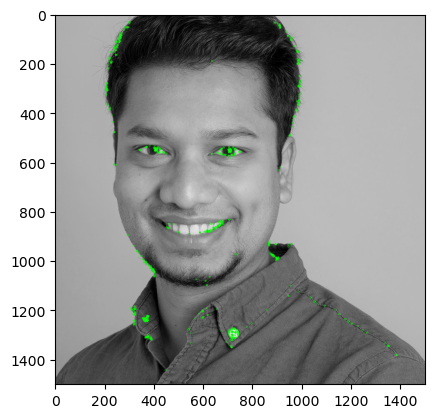

In [2]:
# Initialize the ORB detector
orb = cv2.ORB_create(nfeatures=1000)

image1 = cv2.imread('RamanGoyal.jpg', cv2.IMREAD_GRAYSCALE)
image2 = image1
# Detect keypoints and compute descriptors for the first image
keypoints1, descriptors1 = orb.detectAndCompute(image1, None)
 
# Detect keypoints and compute descriptors for the second image
keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

# Draw keypoints on the image for visualization
image_with_keypoints = cv2.drawKeypoints(image1, keypoints1, None, color=(0, 255, 0), flags=0)

plt.imshow(image_with_keypoints)



Feature Matching    

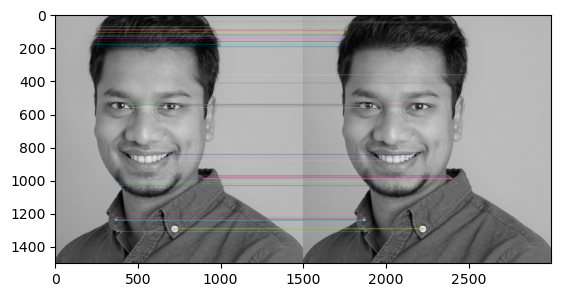

In [3]:
# Initialize the BFMatcher with default params
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

match = bf.match(descriptors1, descriptors2)

match = sorted(match, key=lambda x: x.distance)

top_matches = match[:50]
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, top_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(matched_image)



In [4]:
# Optionally, extract the matched points
matched_points1 = np.float32([keypoints1[m.queryIdx].pt for m in match])
matched_points2 = np.float32([keypoints2[m.trainIdx].pt for m in match])

# Print the coordinates of the matched points
print("Matched points in frame I:")
print(matched_points1)
print("Matched points in frame I+1:")
print(matched_points2)

Matched points in frame I:
[[ 266.        94.     ]
 [ 379.      1224.     ]
 [ 886.       983.     ]
 ...
 [ 318.9032  1261.28   ]
 [ 318.9032  1243.3641 ]
 [ 945.96     935.21045]]
Matched points in frame I+1:
[[ 266.        94.     ]
 [ 379.      1224.     ]
 [ 886.       983.     ]
 ...
 [ 318.9032  1261.28   ]
 [ 318.9032  1243.3641 ]
 [ 945.96     935.21045]]


Feature Tracking

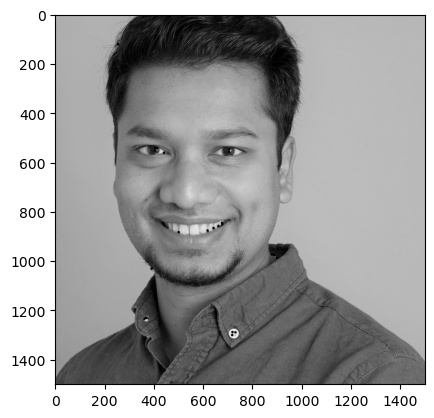

In [5]:
# Detect feature points in the first image (for example, using goodFeaturesToTrack)
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
points1 = cv2.goodFeaturesToTrack(image1, mask=None, **feature_params)


# Parameters for lucas kanade optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


# Calculate optical flow
points2, status, err = cv2.calcOpticalFlowPyrLK(image1, image2, points1, None, **lk_params)
 
# Select good points
good_new = points2[status.ravel() == 1]
good_old = points1[status.ravel() == 1]

# Create a mask image for drawing purposes
mask = np.zeros_like(image1)

# Draw the tracks
for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = new.ravel()
    c, d = old.ravel()
    mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
    image2 = cv2.circle(image2, (int(a), int(b)), 5, (0, 255, 0), -1)

img = cv2.add(image2, mask)

# Convert to RGB for Matplotlib
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

Pose Estimation

In [6]:
# Camera intrinsic parameters (example values, replace with your camera's calibration data)
K = np.array([[3177.000, 0, 1632.000],[0, 3177.00, 1224.00],[0, 0, 1]])

# Extract matched keypoints
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in match])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in match])
 
 
# Compute the Fundamental matrix using RANSAC
F, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
 
# Select inlier points
pts1_inliers = pts1[inliers.ravel() == 1]
pts2_inliers = pts2[inliers.ravel() == 1]

# Compute the Essential matrix using the camera's intrinsic parameters 
E = K.T @ F @ K
 
# Decompose the Essential matrix to get R and t
_, R, t, mask = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)

print("Rotation matrix R:")
print(R)
print("Translation vector t:")
print(t)

Rotation matrix R:
[[-0.90540537  0.12123117 -0.40687113]
 [ 0.12123117 -0.84463181 -0.52144041]
 [-0.40687113 -0.52144041  0.75003719]]
Translation vector t:
[[-0.21747946]
 [-0.27871866]
 [ 0.93542429]]


In [11]:
def add_ones(x):
    return np.concatenate([x, np.ones((x.shape[0], 1))], axis=1)

T = np.eye(4) 
T[0:3,0:3] = R
T[0:3,3] = t.T
Kinv = np.linalg.inv(K)
pose1 = np.eye(4)
pose2 = np.eye(4) @ T

# Optionally, extract the matched points
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in match])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in match])

ret = np.zeros((pts1.shape[0], 4))
pose1 = np.linalg.inv(pose1)
pose2 = np.linalg.inv(pose2)
for i, p in enumerate(zip(add_ones(pts1), 
                          add_ones(pts2))):
    A = np.zeros((4, 4))
    A[0] = p[0][0] * pose1[2] - pose1[0]
    A[1] = p[0][1] * pose1[2] - pose1[1]
    A[2] = p[1][0] * pose2[2] - pose2[0]
    A[3] = p[1][1] * pose2[2] - pose2[1]
    _, _, vt = np.linalg.svd(A)
    ret[i] = vt[3]

ret /= ret[:, 3:]
good_pts4d =   (np.abs(ret[:, 3]) > 0.005) & (ret[:, 2] > 0)

mapp_pts = [p for i, p in enumerate(ret) if good_pts4d[i]]

len(mapp_pts)

0

Save Map in a File


In [8]:
import open3d as o3d
import numpy as np

# Assume mapp_pts is a list of 3D points obtained from the previous code
mapp_pts = np.array(mapp_pts)  # Convert to a NumPy array if it's not already

# Create a PointCloud object
pcd = o3d.geometry.PointCloud()

# Convert the NumPy array to Open3D format
pcd.points = o3d.utility.Vector3dVector(mapp_pts[:, :3])

# Create an array of white colors
colors = np.zeros((mapp_pts.shape[0], 3))
colors[:, 1] = 1  # Set the green channel to 1

# Assign the colors to the point cloud
pcd.colors = o3d.utility.Vector3dVector(colors)

# Save the point cloud to a .pcd file
o3d.io.write_point_cloud("points_colored_structurev2.ply", pcd)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed